<a href="https://colab.research.google.com/github/ahmad-PH/iml_group_proj/blob/main/LibOfCongress_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

# Do the same but pick GPU
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')
#!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

1


In [2]:
# Checking for GPU in an environment
dev = cuda0
t1 = torch.ones(3, 3, device = dev)
print(t1)

torch.cuda.empty_cache()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers

In [5]:
import os
import time
import pickle
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple, NamedTuple, Any
from transformers import BertModel, BertTokenizer

DATA_PATH = "github_data"
# BERT_MODEL_NAME = "prajjwal1/bert-tiny"
# BERT_MODEL_NAME = "prajjwal1/bert-small" # F1-score of 0.73
BERT_MODEL_NAME = "bert-base-uncased" # F1-score of 0.77

# Could effect the record with synopsis, but as there aren't many with tokens > 512, ignore for now
MAX_TOKENS_LENGTH = 512 

VERBOSE = True

def tuple_to_df(data: List[Tuple]) -> pd.DataFrame:
    return pd.DataFrame(data, columns=["class", "title", "synopsis", "id"])


def tuple_to_df(data: List[Tuple]) -> pd.DataFrame:
    return pd.DataFrame(data, columns=["class", "title", "synopsis", "id"])

def load(data_path):
    with open(data_path, 'rb') as f:
        classes = pickle.load(f)
        train = pickle.load(f)
        test = pickle.load(f)

        return classes, tuple_to_df(train), tuple_to_df(test)

_, train, test = load("/content/drive/My Drive/trainTest.pk")
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
model = BertModel.from_pretrained(BERT_MODEL_NAME)

def vprint(s):
    if VERBOSE:
        print(s)

class BertData(NamedTuple):
    train_title_embds: Any = None
    train_sypnosis_embds: Any = None
    test_title_embds: Any = None
    test_sypnosis_embds: Any = None

def from_sentences_to_bert_embeddings(sentences: List[str]):
    outputs = []
    for sentence in tqdm(sentences):
        inputs = bert_tokenizer(sentence, truncation=True, max_length=MAX_TOKENS_LENGTH, return_tensors="pt")
        output = model(**inputs)
        outputs.append(output.last_hidden_state.squeeze(0).detach().numpy())
    return outputs

vprint("Getting BERT embeddings...")

result = []

import os

BERT_FILE = "/content/bert_data_base_uncase.pk"
if not os.path.isfile(BERT_FILE):
  print("File not found, loading...")
  for (titles, synopsis, name) in [(test.title, test.synopsis, "test"),(train.title, train.synopsis, "train")]:
      title_embeddings = from_sentences_to_bert_embeddings(titles)
      synopsis_embeddings = from_sentences_to_bert_embeddings(synopsis)
      assert len(title_embeddings) == len(synopsis_embeddings), f"Title lengths({len(title_embeddings)}) is not equal to synopsis's({len(synopsis_embeddings)})"
      result.append([title_embeddings, synopsis_embeddings])
  data = BertData(result[-1][0], result[-1][1], result[0][0], result[0][1])
  with open(BERT_FILE, 'wb') as f:
      pickle.dump(data, f)
else:
  print("File found, loading...")
  with open(BERT_FILE, "rb") as f:
    data = pickle.load(f)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting BERT embeddings...
File found, loading...


In [6]:
data.train_sypnosis_embds[0].shape

(17, 768)

In [8]:
import numpy as np
from abc import ABC
import pandas as pd
from typing import Iterable, Tuple, List, NamedTuple, Any
import torch
from os import PathLike, path
import pickle
from sklearn import preprocessing
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence
# DATA

class DataBase(ABC, Iterable):
    def __len__(self):
        'Denotes the total number of samples' 
        pass

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        pass

    def get_all(self):
        'Generates one sample of data'
        # Select sample
        pass

    def __iter__(self):
        pass

    def __next__(self): 
        pass

def load_pickle_bert(file_path: str) -> BertData:
    with open(path.join(file_path, 'bert_train.pk'), 'rb') as f:
        [tr_title_embeddings, tr_synopsis_embeddings] = pickle.load(f)

    with open(path.join(file_path, 'bert_test.pk'), 'rb') as f:
        [te_title_embeddings, te_synopsis_embeddings] = pickle.load(f)

    return BertData(
            tr_title_embeddings,
            tr_synopsis_embeddings,
            te_title_embeddings,
            te_synopsis_embeddings
            )

class Keys:
    TRAIN_TITLE="train_title" 
    TRAIN_SYN="train_synopsis"
    TEST_TITLE="test_title"
    TEST_SYN="test_synopsis"


def prep_embds(embds):
    sentence_lengths = np.array([e.shape[0] for e in embds])
    sentence_lengths = np.argsort(-sentence_lengths)
    return (np.array([torch.Tensor(e).to(dev) for e in embds], dtype=object), sentence_lengths)

class DatasetRaw(DataBase):
    def __init__(self, data: BertData, batch_size:int=512, shuffle:bool=True, max_words:int=100):
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(train["class"])
        y_test = le.transform(test["class"])

        self.data = data

        self.features = {}
        self.features[Keys.TRAIN_SYN], train_idxes = prep_embds(data.train_sypnosis_embds)
        self.features[Keys.TRAIN_SYN] = self.features[Keys.TRAIN_SYN][train_idxes]
        self.features[Keys.TRAIN_TITLE], _ = prep_embds(data.train_title_embds)
        self.features[Keys.TRAIN_TITLE] = self.features[Keys.TRAIN_TITLE][train_idxes]
        
        self.features[Keys.TEST_SYN], test_idxes = prep_embds(data.test_sypnosis_embds)
        self.features[Keys.TEST_SYN] = self.features[Keys.TEST_SYN][test_idxes]
        self.features[Keys.TEST_TITLE], _ = prep_embds(data.test_title_embds)
        self.features[Keys.TEST_TITLE] = self.features[Keys.TEST_TITLE][test_idxes]
        
        self.train_length = len(self.features[Keys.TRAIN_TITLE])
        
        self.y_train = torch.Tensor(y_train[train_idxes]).long().to(dev)
        self.y_test = torch.Tensor(y_test[test_idxes]).long().to(dev)

        self.batch_size = batch_size
        self.current = 0
        self.shuffle = shuffle

        self.epoch_idxes = np.arange(self.train_length,dtype=int)
        if self.shuffle:
            np.random.shuffle(self.epoch_idxes)


    def __len__(self):
        'Denotes the total number of samples' 
        return self.train_length

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.features[Keys.TRAIN_TITLE][index], self.y_train[index]

    def pack(self, title, synop):
        t_padded = pack_sequence(list(title), enforce_sorted=False)
        s_padded = pack_sequence(list(synop))

        return {
                "x":t_padded,
                "synop":s_padded,
                "x_lengths":len(title)
                }

    def get_all(self):
        # Do paddings
        return (
                #self.pack(self.features[Keys.TRAIN_TITLE], self.features[Keys.TRAIN_SYN]),
                #self.y_train,
                self.pack(self.features[Keys.TEST_TITLE], self.features[Keys.TEST_SYN]),
                self.y_test
                )

    def __iter__(self):
        return self

    def __next__(self):
        # TODO: Batch sorted by sentence sizes, shuffle only batch but not inside the batch.
        if self.current >= self.train_length:
            self.current = 0
            if self.shuffle:
                np.random.shuffle(self.epoch_idxes)
            raise StopIteration

        c = self.current
        self.current += self.batch_size
        selecting_row = self.epoch_idxes[c:c+self.batch_size]
        return self.pack(self.features[Keys.TRAIN_TITLE][selecting_row], self.features[Keys.TRAIN_SYN][selecting_row]), self.y_train[selecting_row]

data_loader = DatasetRaw(data, shuffle=False)
data_loader.__next__()
print("passed")

passed


In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence

class GRU(nn.Module):
    def __init__(self, input_dims: int, num_class: int, hidden_dim:int, num_layers: int):
        super().__init__()
        self.hidden_dim = hidden_dim        
        self.lstm_layers = num_layers

        self.EMB_SIZE = input_dims
        self.title_gru = nn.GRU(input_dims, self.hidden_dim, self.lstm_layers, batch_first=True)
        self.synop_gru = nn.GRU(input_dims, self.hidden_dim, self.lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)

        self.final = nn.Linear(self.hidden_dim * 2, num_class)
        self.relu = nn.ReLU()

    # Expect 1 row for now
    def forward(self, x, x_lengths, synop):
        h_0 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state

        title_gru_out, _ = self.title_gru(x, h_0)
        seq_unpacked, lens_unpacked = pad_packed_sequence(title_gru_out, batch_first=True)
        title_outputs = self.last_timestep(seq_unpacked, lens_unpacked)

        h_1 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state
        synop_gru_out, _ = self.synop_gru(synop, h_1)
        seq_unpacked, lens_unpacked = pad_packed_sequence(synop_gru_out, batch_first=True)
        synop_outputs = self.last_timestep(seq_unpacked, lens_unpacked)

        output = torch.cat((title_outputs, synop_outputs), dim=1)
        output = self.final(output)
        return output


    def last_timestep(self, unpacked, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(unpacked.size(0),
                                               unpacked.size(2)).unsqueeze(1).to(dev)
        return unpacked.gather(1, idx).squeeze()

    def predict(self, X):
        return torch.argmax(self.forward(**X), dim=1)

In [10]:
from tqdm import tqdm
from typing import Dict, Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import functools
import numpy as np
import pandas as pd
from typing import Callable, Dict, List, Any
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
RANDOM_STATE = 1024
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

class TrainedModel(NamedTuple):
    name: str
    model: Any # Any function that has .predict_proba()
    info: Dict[str, Any] # Information about the training (e.g., is_train?, with_sypnosis?)      


def evaluate_many(models: List[TrainedModel],X_test, y_test):
    results = []
    for trained_model in models:
        clf = trained_model.model
        y_test_pred = clf.predict(X_test).cpu()

        test_row = evaluate(y_test_pred, y_test.cpu(), trained_model.name, trained_model.info)
        test_row["is_train"] = False
        results.append(test_row)

    return pd.DataFrame(results)
  
def precision_recall_f1(label, prediction) -> Dict[str, float]:
    p, r, f, _ = precision_recall_fscore_support(label, prediction, average="macro")

    return {
            "precision": p,
            "recall": r,
            "f1_score": f
    }

def accuracy(label, prediction) -> Dict[str, float]:
    return {
            "accuracy": accuracy_score(label, prediction)
            }

def evaluate(
        prediction,
        label,
        name: str,
        info: Dict[str, Any],
        flows: List[Callable] = [accuracy, precision_recall_f1]
        ):

    flows = flows + [lambda a, b: {"name": name}]
    results = [f(label, prediction) for f in flows] + [info]

    return functools.reduce(
        lambda a,b: {**a, **b}, # Adding two dicts together.
        results
        )

class PyTorchTrainer():

    @staticmethod
    def fit(
            data_loader: DataBase,
            model: nn.Module,
            train_params: Dict[str, Any],
            on_epoch_end: Callable,
            ):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=train_params.get("lr", 0.0001))
        early_stopping_num = train_params.get("early_stopping_num", None)
        last_round_eval_loss = 0

        X_test, y_test = data_loader.get_all()

        for epoch in tqdm(range(train_params.get("epochs", 10)), desc="epochs"):  # loop over the dataset multiple times
            running_loss = 0.0
            metrics = {
                "losses": [],
                "epochs": epoch
            }
            for i, (inputs, labels) in enumerate(data_loader):
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                metrics["losses"].append(loss.item())
                loss.backward()
                optimizer.step()
            
            eval_loss = criterion(model(**X_test), y_test)
            metrics["eval_loss"] = eval_loss.item()
            on_epoch_end(metrics)
            if epoch % 5 == 0:
              print("==")
              print(f"Train loss: {loss.item():.5f}")
              print(f"Eval  loss: {eval_loss.item():.5f}")
              print(f"Improvement: {last_round_eval_loss - eval_loss}")
              print("==")

            if early_stopping_num is not None and (last_round_eval_loss - eval_loss) < train_params.get("delta", 0.001):
                early_stopping_num -= 1
                if early_stopping_num <= 0:
                    print("Early stopping! Eval loss hasn't improved for sometimes")
                    break
            else:
              # Reset the early stopping count
              early_stopping_num = train_params.get("early_stopping_num", None)

            last_round_eval_loss = eval_loss
            if epoch % train_params.get("report_epochs", 30) == (train_params.get("report_epochs",30) - 1):
                _model = TrainedModel(name="pytorch_mlp", model=model, info={"epochs": epoch})
                result_df_1 = evaluate_many([_model], X_test, y_test)
                print("===")
                print(result_df_1.head(10))
            
        print("Training done!")
        result_df_1 = evaluate_many([_model], X_test, y_test)
        print("===")
        print(result_df_1.head(10))        
        return None

epochs:   0%|          | 0/600 [00:00<?, ?it/s]

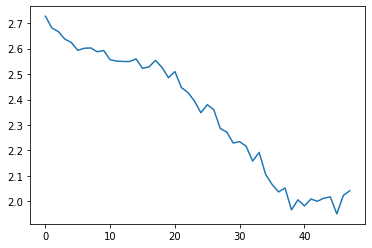

epochs:   0%|          | 1/600 [00:02<27:11,  2.72s/it]

==
Train loss: 2.04165
Eval  loss: 1.85277
Improvement: -1.8527748584747314
==


epochs:   1%|          | 6/600 [00:14<22:49,  2.31s/it]

==
Train loss: 0.80090
Eval  loss: 0.84892
Improvement: 0.02441394329071045
==


epochs:   2%|▏         | 10/600 [00:23<21:06,  2.15s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.749667   0.754306  0.749667  0.747978  pytorch_mlp       9     False


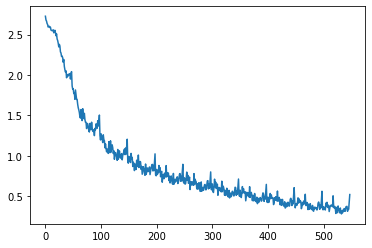

epochs:   2%|▏         | 11/600 [00:25<21:15,  2.16s/it]

==
Train loss: 0.52081
Eval  loss: 0.85476
Improvement: 0.01359093189239502
==


epochs:   3%|▎         | 16/600 [00:35<20:36,  2.12s/it]

==
Train loss: 0.35004
Eval  loss: 0.99897
Improvement: -0.024458706378936768
==


epochs:   3%|▎         | 20/600 [00:44<20:15,  2.09s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.736333   0.750052  0.736333  0.737545  pytorch_mlp      19     False


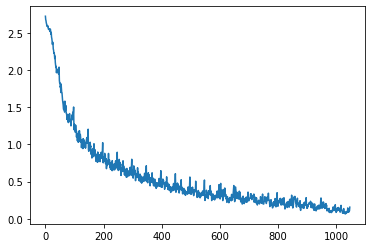

epochs:   4%|▎         | 21/600 [00:46<20:41,  2.14s/it]

==
Train loss: 0.15539
Eval  loss: 1.09368
Improvement: -0.002447962760925293
==


epochs:   4%|▍         | 26/600 [00:57<20:21,  2.13s/it]

==
Train loss: 0.09570
Eval  loss: 1.21691
Improvement: -0.018706440925598145
==


epochs:   5%|▌         | 30/600 [01:06<21:18,  2.24s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.735667   0.754757  0.735667   0.73768  pytorch_mlp      29     False


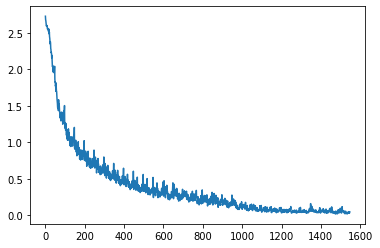

epochs:   5%|▌         | 31/600 [01:09<23:14,  2.45s/it]

==
Train loss: 0.04938
Eval  loss: 1.20262
Improvement: 0.08142721652984619
==


epochs:   6%|▌         | 36/600 [01:20<21:25,  2.28s/it]

==
Train loss: 0.02653
Eval  loss: 1.26453
Improvement: -0.01029503345489502
==


epochs:   7%|▋         | 40/600 [01:28<20:05,  2.15s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.758333   0.761759  0.758333  0.758479  pytorch_mlp      39     False


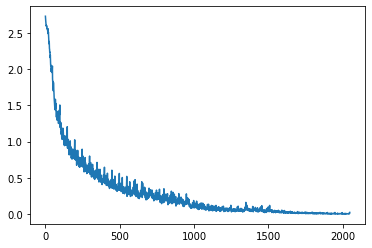

epochs:   7%|▋         | 41/600 [01:30<20:11,  2.17s/it]

==
Train loss: 0.02434
Eval  loss: 1.31929
Improvement: 0.008039116859436035
==


epochs:   8%|▊         | 46/600 [01:41<19:24,  2.10s/it]

==
Train loss: 0.00975
Eval  loss: 1.34071
Improvement: -0.0022808313369750977
==


epochs:   8%|▊         | 50/600 [01:49<19:11,  2.09s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.764667   0.764632  0.764667  0.764292  pytorch_mlp      49     False


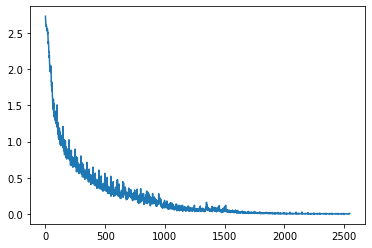

epochs:   8%|▊         | 51/600 [01:51<19:37,  2.15s/it]

==
Train loss: 0.00711
Eval  loss: 1.37526
Improvement: -0.008182764053344727
==


epochs:   9%|▉         | 56/600 [02:02<19:11,  2.12s/it]

==
Train loss: 0.00565
Eval  loss: 1.41337
Improvement: -0.0072067975997924805
==


epochs:  10%|▉         | 59/600 [02:10<19:59,  2.22s/it]

Early stopping! Eval loss hasn't improved for sometimes
Training done!
===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.760333    0.76091  0.760333  0.760254  pytorch_mlp      49     False


In [11]:
import matplotlib.pyplot as plt
training_params = {
        "epochs": 600,
        "lr": 0.001,
        "report_epochs":5,
        "early_stopping_num": 15,
        "delta": 0.0001
}

tmp, _ = data_loader.__next__()
model = GRU(data_loader[0][0].shape[1], 15, 64, 2).to(dev)
lstm_output = model.forward(**tmp)

losses = []
def report(metrics):
  losses.extend(metrics["losses"])
  if metrics["epochs"] % 10 == 0:
    plt.clf()
    plt.plot(losses)
    plt.show()

PyTorchTrainer.fit(data_loader, model, training_params, report)

In [16]:
torch.save(model, "/content/bert_gru_786.pt")